Implementation of the FFNN with a bag-of-words model.

In [16]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.nn import relu, softmax
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tensorflow.contrib.layers import fully_connected, flatten, batch_norm, dropout
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix 


#import training, validation and test set
with open('train_sentences_id_balanced.pickle','rb') as file:
    training_sentences = pickle.load(file)
    
with open('train_labels_balanced.pickle','rb') as file:
    training_bin_labels = pickle.load(file)
    

    
with open('valid_sentences_id_balanced.pickle','rb') as file:
    validation_sentences = pickle.load(file)
    
with open('valid_labels_balanced.pickle','rb') as file:
    validation_bin_labels = pickle.load(file)
    
    
    
with open('test_sentences_id_balanced.pickle','rb') as file:
    test_sentences = pickle.load(file)
    
with open('test_labels_balanced.pickle','rb') as file:
    test_bin_labels = pickle.load(file)
    
with open('test_word_sentences_balanced.pickle','rb') as file:
    test_word_sentences = pickle.load(file)
 

print(test_sentences[0][:])
print(test_word_sentences[0])
print(test_bin_labels[0])
 

[2363, 10141, 9107, 10, 4223, 5103, 3116, 10280]
['Finanseksperter vurderer at de kan tjene 100% af den investering, de laver, på få år.']
1.0


In [17]:
def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() ) 
    return list_of_objects

In [18]:
#information about the dataset

num_training=len(training_sentences)
num_valid=len(validation_sentences)
num_test=len(test_sentences)
num_words=max(max(max(training_sentences)),max(max(validation_sentences)),max(max(test_sentences)))
num_claims_train=sum(training_bin_labels)
num_claims_valid=sum(validation_bin_labels)
num_claims_test=sum(test_bin_labels)

print('total number of sentences:',num_training+num_valid+num_test)
print('number of training exemples:',num_training)
print('number of validation exemples:',num_valid)
print('number of test exemples:',num_test)
print('total number of words:',num_words)
print('Total number of claims: ', num_claims_train+num_claims_valid+num_claims_test)
print('Number of claims in the training set: ', num_claims_train)
print('Number of claims in the validation set: ', num_claims_valid)
print('Number of claims in the test set: ', num_claims_test)


#prosessing inputs

train_exemples = np.zeros((num_training, num_words))
valid_exemples = np.zeros((num_valid, num_words))
test_exemples = np.zeros((num_test, num_words))
for (i,sent) in enumerate(training_sentences):
        for (j,word) in enumerate(sent):
            train_exemples[i,word-1] = 1
for (i,sent) in enumerate(validation_sentences):
        for (j,word) in enumerate(sent):
            valid_exemples[i,word-1] = 1
for (i,sent) in enumerate(test_sentences):
        for (j,word) in enumerate(sent):
            test_exemples[i,word-1] = 1



total number of sentences: 13578
number of training exemples: 8149
number of validation exemples: 2629
number of test exemples: 2800
total number of words: 10391
Total number of claims:  5680.0
Number of claims in the training set:  3410.0
Number of claims in the validation set:  1040.0
Number of claims in the test set:  1230.0


In [19]:
#processing labels
train_labels=np.zeros((len(training_bin_labels),2))
valid_labels=np.zeros((len(validation_bin_labels),2))
test_labels=np.zeros((len(test_bin_labels),2))

for (i,lab) in enumerate(training_bin_labels):
    if(lab==1):
        train_labels[i,1]=1
    else:
        train_labels[i,0]=1
for (i,lab) in enumerate(validation_bin_labels):
    if(lab==1):
        valid_labels[i,1]=1
    else:
        valid_labels[i,0]=1
for (i,lab) in enumerate(test_bin_labels):
    if(lab==1):
        test_labels[i,1]=1
    else:
        test_labels[i,0]=1
        
   


In [20]:
dim_input=num_words
dim_output=train_labels.shape[1]
print('training exemples shape: ', train_exemples.shape)
print('training labels shape: ', train_labels.shape)
print('input dimension:', dim_input)
print('output dimension:',dim_output)

training exemples shape:  (8149, 10391)
training labels shape:  (8149, 2)
input dimension: 10391
output dimension: 2


In [21]:
## Build the network
tf.reset_default_graph()


## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, dim_input], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, dim_output], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)
threshold_pl=tf.placeholder(tf.float32, shape=[], name='thresholdPlaceholder')
dropout_pl=tf.placeholder(tf.float32, shape=[], name='dropoutPlaceholder')

## Define the model
n_hidden1=3;
n_hidden2=3;

l_hidden1 = tf.layers.dense(inputs=x_pl, units=n_hidden1, activation=relu, name='l_hidden1')
l1_dropout = dropout(l_hidden1, dropout_pl, scope="l1_dropout",)
l_hidden2 = tf.layers.dense(inputs=l1_dropout, units=n_hidden2, activation=relu, name='l_hidden2')
l2_dropout = dropout(l_hidden2, dropout_pl, scope="l2_dropout",)
y = tf.layers.dense(inputs=l2_dropout, units=dim_output, activation=softmax, name='l_out')



# print network
print('x_pl:', x_pl.get_shape())
print('y_pl:', y_pl.get_shape())
print('l_hidden1:', l_hidden1.get_shape())
print('l_hidden2:', l_hidden2.get_shape())
print('y:', y.get_shape())




x_pl: (?, 10391)
y_pl: (?, 2)
l_hidden1: (?, 3)
l_hidden2: (?, 3)
y: (?, 2)


In [22]:
# 1) Define cross entropy loss
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    loss = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])
    # Average over samples
    loss = tf.reduce_mean(loss)
    # regularization
    reg_scale = 0.0001
    regularize = tf.contrib.layers.l1_regularizer(reg_scale)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    reg_term = sum([regularize(param) for param in params])
    loss += reg_term

# 2) Define the training op
with tf.variable_scope('trainOP'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    train_op = optimizer.minimize(loss)


with tf.variable_scope('performance'):
        binary_pred=tf.greater(y[:,1], threshold_pl)
        binary_pred=tf.cast(binary_pred,tf.int64, name='predictions')
        binary_labels=tf.argmax(y_pl, axis=1)
        # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
        correct_prediction = tf.equal(binary_pred, binary_labels)
        # averaging the one-hot encoded vector
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
        _, auc_op = tf.contrib.metrics.streaming_auc(predictions=y[:,1], labels=binary_labels, num_thresholds=300, name='auc')
        _, sensitivity_op= tf.metrics.recall(binary_labels, binary_pred, name='sensitivity')
        conf_matrix = tf.confusion_matrix(labels=binary_labels, predictions=binary_pred, num_classes=2)
        specificity = tf.divide(conf_matrix[0,0], conf_matrix[0,0] + conf_matrix[0,1], name='specificity') 
        

In [23]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.35)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.global_variables_initializer())


In [24]:
#Test the forward pass
batch_size = 32

# Get a mini-batch
x_batch=train_exemples[0:batch_size,:]
print('x_batch shape:',np.shape(x_batch))
y_batch=train_labels[0:batch_size,:]
print('y_batch shape:',np.shape(y_batch))


feed_dict = {x_pl: x_batch, dropout_pl: 1}
fetches = [y] 
[y_pred] = sess.run( fetches, feed_dict )

        
assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y_batch.shape) + ' but was ' + str(y_pred.shape)

x_batch shape: (32, 10391)
y_batch shape: (32, 2)


In [25]:
def get_batch(batch_size=32, random=False, k=0):
    
    if random==True:
        indexes=np.random.choice(np.arange(num_training), (batch_size,), False)
        batch_exemples = train_exemples[indexes,:]
        batch_labels = train_labels[indexes,:]
        return batch_exemples, batch_labels

    
    else:
        if (k+batch_size<num_training or k+batch_size==num_training):
            batch_exemples = train_exemples[k:batch_size+k,:]
            batch_labels = train_labels[k:batch_size+k,:]
            index=k+batch_size
        else:
            batch_exemples = np.concatenate((train_exemples[k:num_training,:],\
                                             train_exemples[0:batch_size-(num_training-k),:]),axis=0) 
            batch_labels = np.concatenate((train_labels[k:num_training,:],\
                                           train_labels[0:batch_size-(num_training-k),:]),axis=0) 
            index=batch_size-(num_training-k)
        
        return batch_exemples, batch_labels, index
    
    


In [26]:
#Training Loop

print('Begin training loop')

# setting up running parameters
BATCH_SIZE = 32
val_interval = 100
batches_to_process = 5e3
batches_processed = 0
threshold=0.35
dropout=0.4
batches_valid, batches_train, = [], []
val_loss, val_acc, val_auc, val_sensitivity, val_specificity = [], [], [], [], []
train_loss, train_acc, train_auc, train_sensitivity, train_specificity = [], [], [], [], []
val_num=0
index=0

try:
    while batches_processed < batches_to_process:
        # load data
        x_batch, y_batch, index = get_batch(batch_size=BATCH_SIZE, random=False, k=index)
            
        fetches_train = [train_op, loss, accuracy, auc_op, sensitivity_op, specificity]
        feed_dict_train = {x_pl: x_batch, y_pl: y_batch, threshold_pl: threshold, dropout_pl: dropout}
        sess.run(tf.local_variables_initializer())
        _, batch_loss, batch_acc, batch_auc, batch_sens, batch_spec = sess.run(fetches_train, feed_dict_train)
        batches_processed += 1
            
        if batches_processed % val_interval == 0:
            train_loss.append(batch_loss)
            train_acc.append(batch_acc)
            train_auc.append(batch_auc)
            train_sensitivity.append(batch_sens)
            train_specificity.append(batch_spec)
            print("Batch number {}: Train Loss {:6.3f},  Train Acc {:6.3f}, Train AUC {:6.3f}, Train Sensitivity {:6.3f}, Train Specificity {:6.3f}".format(
                    batches_processed, train_loss[-1], train_acc[-1], train_auc[-1], train_sensitivity[-1], train_specificity[-1]))
            
            #validation
            val_num=val_num+1
            fetches_valid = [loss, accuracy, auc_op, sensitivity_op, specificity]
            feed_dict_valid = {x_pl: valid_exemples, y_pl: valid_labels, threshold_pl: threshold, dropout_pl:1}
            sess.run(tf.local_variables_initializer())
            _loss, _acc, _auc, _sensitivity, _specificity = sess.run(fetches_valid, feed_dict_valid)
            val_loss.append(_loss)
            val_acc.append(_acc)
            val_auc.append(_auc)
            val_sensitivity.append(_sensitivity)
            val_specificity.append(_specificity)
            batches_valid += [batches_processed]
            print("Validation number {}: Val Loss {:6.3f},  Val Acc {:6.3f}, Val AUC {:6.3f}, Val Sensitivity {:6.3f}, Val Specificity {:6.3f}".format(
                    val_num, val_loss[-1], val_acc[-1], val_auc[-1], val_sensitivity[-1], val_specificity[-1]))
     
    #test
    feed_dict_test = {x_pl: test_exemples, y_pl: test_labels, threshold_pl: threshold, dropout_pl:1} 
    fetches_test = [loss, accuracy, auc_op, sensitivity_op, specificity, binary_labels, binary_pred, y]
    sess.run(tf.local_variables_initializer())
    test_loss, test_acc, test_auc, test_sens, test_spec, test_bin_labels, test_pred, test_prob = sess.run(fetches_test, feed_dict_test)
    
    fpr_test, tpr_test, _ = roc_curve(test_bin_labels, test_prob[:,1])
    roc_auc_test = auc(fpr_test, tpr_test)
    TN, FP, FN, TP = confusion_matrix(test_bin_labels, test_pred).ravel()

    test_accuracy=(TN+TP)/float(TN+FP+FN+TP) #prop di risposte corrette in tot
    test_sensitivity = TP / float(FN + TP) #veri p
    test_specificity = TN / (TN + FP) #
    print('Test Loss {:6.3f}, Test Acc {:6.3f}, Test AUC {:6.3f}, Test Sensitivity {:6.3f}, Test Specificity {:6.3f}'.format(
                    test_loss, test_acc, test_auc, test_sens, test_spec))
    print('Test Loss {:6.3f}, Test Acc {:6.3f}, Test AUC {:6.3f}, Test Sensitivity {:6.3f}, Test Specificity {:6.3f}'.format(
                    test_loss, test_accuracy, roc_auc_test, test_sensitivity, test_specificity))
except KeyboardInterrupt:
    pass

print('Done')
           

Begin training loop
Batch number 100: Train Loss  0.707,  Train Acc  0.281, Train AUC  0.591, Train Sensitivity  0.900, Train Specificity  0.000
Validation number 1: Val Loss  0.703,  Val Acc  0.396, Val AUC  0.482, Val Sensitivity  1.000, Val Specificity  0.000
Batch number 200: Train Loss  0.702,  Train Acc  0.438, Train AUC  0.440, Train Sensitivity  1.000, Train Specificity  0.000
Validation number 2: Val Loss  0.691,  Val Acc  0.396, Val AUC  0.507, Val Sensitivity  1.000, Val Specificity  0.000
Batch number 300: Train Loss  0.690,  Train Acc  0.406, Train AUC  0.518, Train Sensitivity  1.000, Train Specificity  0.000
Validation number 3: Val Loss  0.687,  Val Acc  0.396, Val AUC  0.537, Val Sensitivity  1.000, Val Specificity  0.000
Batch number 400: Train Loss  0.699,  Train Acc  0.500, Train AUC  0.582, Train Sensitivity  1.000, Train Specificity  0.000
Validation number 4: Val Loss  0.685,  Val Acc  0.396, Val AUC  0.571, Val Sensitivity  1.000, Val Specificity  0.000
Batch nu

Batch number 3500: Train Loss  0.648,  Train Acc  0.625, Train AUC  0.643, Train Sensitivity  1.000, Train Specificity  0.250
Validation number 35: Val Loss  0.649,  Val Acc  0.565, Val AUC  0.711, Val Sensitivity  0.788, Val Specificity  0.419
Batch number 3600: Train Loss  0.665,  Train Acc  0.562, Train AUC  0.506, Train Sensitivity  1.000, Train Specificity  0.176
Validation number 36: Val Loss  0.648,  Val Acc  0.567, Val AUC  0.713, Val Sensitivity  0.788, Val Specificity  0.422
Batch number 3700: Train Loss  0.632,  Train Acc  0.531, Train AUC  0.650, Train Sensitivity  1.000, Train Specificity  0.211
Validation number 37: Val Loss  0.648,  Val Acc  0.587, Val AUC  0.713, Val Sensitivity  0.788, Val Specificity  0.454
Batch number 3800: Train Loss  0.657,  Train Acc  0.719, Train AUC  0.652, Train Sensitivity  1.000, Train Specificity  0.308
Validation number 38: Val Loss  0.647,  Val Acc  0.597, Val AUC  0.715, Val Sensitivity  0.788, Val Specificity  0.471
Batch number 3900: T

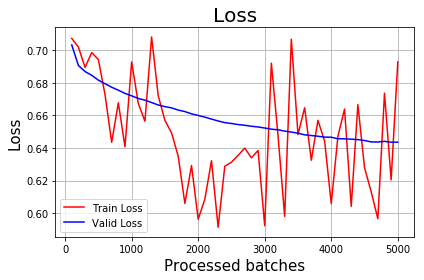

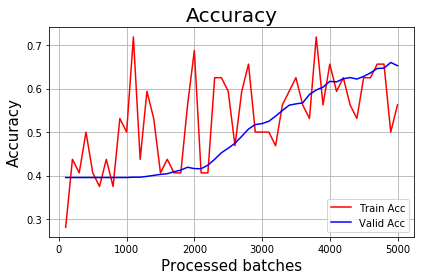

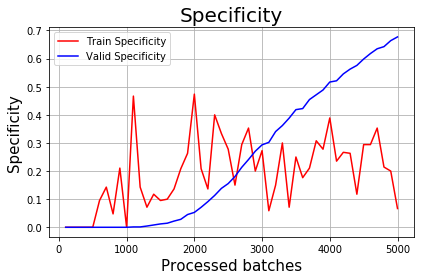

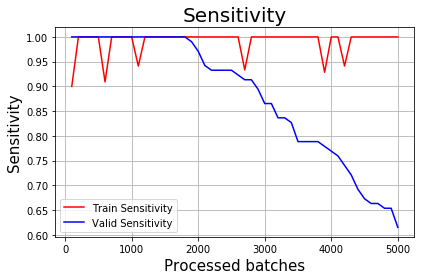

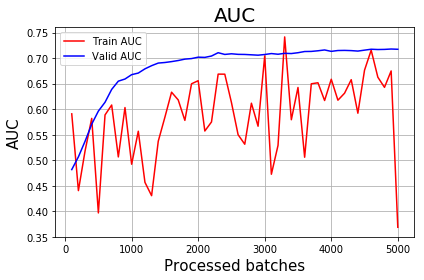

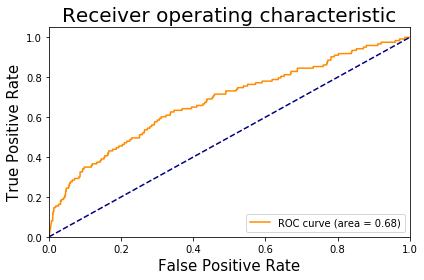

In [27]:
#plot learning curves

fig=plt.figure()
fig.add_subplot()
plt.plot(batches_valid, train_loss, 'r-', label='Train Loss')
plt.plot(batches_valid, val_loss, 'b-', label='Valid Loss')
plt.legend()
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('Loss', fontsize=20)
plt.grid('on')
plt.tight_layout()
plt.show()    
            
fig.add_subplot()
plt.plot(batches_valid, train_acc, 'r-', label='Train Acc')
plt.plot(batches_valid, val_acc, 'b-', label='Valid Acc')
plt.legend()
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('Accuracy', fontsize=20)
plt.grid('on')
plt.tight_layout()
plt.show()       


fig=plt.figure()
fig.add_subplot()
plt.plot(batches_valid, train_specificity, 'r-', label='Train Specificity')
plt.plot(batches_valid, val_specificity, 'b-', label='Valid Specificity')
plt.legend()
plt.ylabel('Specificity', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('Specificity', fontsize=20)
plt.grid('on') 
plt.tight_layout()
plt.show()       
    
fig.add_subplot()
plt.plot(batches_valid, train_sensitivity, 'r-', label='Train Sensitivity')
plt.plot(batches_valid, val_sensitivity, 'b-', label='Valid Sensitivity')
plt.legend()
plt.ylabel('Sensitivity', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('Sensitivity', fontsize=20)
plt.grid('on')
plt.tight_layout()
plt.show()   

plt.figure()
plt.plot(batches_valid, train_auc, 'r-', label='Train AUC')
plt.plot(batches_valid, val_auc, 'b-', label='Valid AUC')
plt.legend()
plt.legend()
plt.ylabel('AUC', fontsize=15)
plt.xlabel('Processed batches', fontsize=15)
plt.title('AUC', fontsize=20)
plt.grid('on')
plt.tight_layout()
plt.show()  

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



In [28]:
#see some exemples

unique_test_sentences = [] 
unique_test_labels = []
unique_test_pred = []


for (i,sent) in enumerate(test_word_sentences):
    if sent not in unique_test_sentences:
        #print(sent)
        unique_test_sentences.append(sent)
        unique_test_labels.append(test_bin_labels[i])
        unique_test_pred.append(test_pred[i])
        
true_pos = []
false_pos = []
true_neg = []
false_neg = []

print('Number of test sentences: ',len(test_word_sentences))
print('Number of unique test sentences: ',len(unique_test_sentences))

for (i,pred) in enumerate(unique_test_pred):
    if(pred==1):
        if (unique_test_labels[i]==1):
            true_pos.append(unique_test_sentences[i])
        else:
             false_pos.append(unique_test_sentences[i])
    else:
        if (unique_test_labels[i]==1):
            false_neg.append(unique_test_sentences[i])
        else:
             true_neg.append(unique_test_sentences[i])
    
print('\nTrue positives: ')
for i in np.arange(min(10,len(true_pos))):
    print(true_pos[i])
print('\nFalse positives: ')
for i in np.arange(min(10,len(false_pos))):
    print(false_pos[i])
print('\nTrue negatives: ')
for i in np.arange(min(10,len(true_neg))):
    print(true_neg[i])
print('\nFalse negatives: ')
for i in np.arange(min(10,len(false_neg))):
    print(false_neg[i])   

Number of test sentences:  2800
Number of unique test sentences:  1689

True positives: 
['Finanseksperter vurderer at de kan tjene 100% af den investering, de laver, på få år.']
['Danmark står i en unik situation, fordi vi er et førerland.']
['Alternative diæter er tidens store sundhedstrend og mange familier følger den nyeste kostreligion.']
['Virksomheder betaler ikke energiafgifter som andre forbrugere.']
['Dumpeprocenterne på de fag er steget fra 10% til 50%.']
['Domstolen siger, at nu kan man gifte sig med en illegal indvandrer og få familiesammenføring. Så bliver det mere attraktivt at søge og at komme herop og få offentlige ydelser.']
['Der er investeret næsten 500 mio. kr. over de første år blandt 3700 indbyggere. Det er rigtig mange penge per indbygger.']
['Vores styrke er, at vi er i stand til at tage nye produktioner op.']
['De vil til næste år beløbe sig til 42 mia. kr.']
['Selv om det måske kun er 500 arbejdspladser skal man gange det tal med fire, fordi underleverandører

In [30]:
## Save model

saver = tf.train.Saver()
saver.save(sess, "./ffnn_3_3")


'./ffnn_3_3'